# DEEPNANO DATA

This part of a tutorial covers most of the operation with a dataset generated by 



By this time the turotial doesn't provide code for a data generation process because of its relative computational complexity. Hopefully, in a future release we will add this functionality in the tutorial. 

## Download and Unpack

To download the dataset using in this tutorial

To unpack data to a folder use 

In [1]:
#directory with .csv files
DATADIR = 'data/'
MODELDIR = 'data/models/'
SOURCEDIR = '../'
#directory with all necessary files including mask, dictionary and spectra files
filedir = '/ibex/scratch/projects/c2064/data/deepnano/data_50_50/'

In [2]:
import numpy as np, os, sys
import matplotlib.pyplot as plt
import matplotlib as ml
from scipy.linalg import norm
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
import sys
from skimage.transform import resize
from skimage.transform import AffineTransform, warp, rotate
if not os.path.abspath(SOURCEDIR) in sys.path:
    sys.path.append(os.path.abspath(SOURCEDIR))

## Structure

In [3]:
data = pd.read_csv(DATADIR + 'data_rect_all_periods.csv',index_col=0)
nshapes = data.types.map(lambda x: len(x.split('-')))
names = data.index.values 
wxs = data.nx.values
wys = data.ny.values

Let's have a close look on how data is stored in DEEPNANO. 

Each dataset has a corresponong .csv file with all necessary information about generated samples. Each sample represents an output from FDTD simulations of a structure with a periodic boundary conditions and random shape as mask with 

In [5]:
data.sample(5)

,dz,overlap,types,nx,ny,status,filedir
URo19NpfC064qo1A9HaV,0.250,True,rectangle-rectangle-rectangle,150,150,test,data_150_150/
4HiOzWDn4nh0JRibr9fW,0.150,False,rectangle-rectangle,50,50,train,data_50_50/
opHDeGDJyw8j3WEHIfp2,0.125,False,rectangle-rectangle-rectangle-rectangle-rectangle,100,100,val,data_100_100/
PBQdAhm37GCz0GqgJxv1,0.050,True,rectangle-rectangle,150,150,test,data_150_150/
spbrquBbQiKV29BBcGKr,0.125,True,rectangle-rectangle,150,150,train,data_150_150/


Each sample represents an output from FDTD simulations of a structure with a periodic boundary conditions and random shape as mask with different thickness and periods. 

To generate a "random" shapes we use an auxillary utils described in shapes.py source file with some examples of usage. In this tutorial we will mention only some key functionality of this class.

In [6]:
MIN_FEATURE_SIZE = 10
from shapes import generate_random_shapes, Shape, Canvas
import pickle
shape = generate_random_shapes(np.zeros([224,224],dtype=np.int32),types=['rectangle','ellipse','ring'],max_shapes=8,min_size=MIN_FEATURE_SIZE)
plt.imshow(shape.mask)
plt.show()

ModuleNotFoundError: No module named 'shapely'

Typicall output from FDTD simulations usually are some physical quntities of interest, such as  flat transmission/reflection response for TE/TM polarized plane wave and corresponding phases.

All this information are stored in a "filedir" folder with unique name using the key value in the dataset for each sample. So, a masked array for a sample with key value '5sboqBZAwrhDPv9nBzgl' in a dataset is named '5sboqBZAwrhDPv9nBzgl-mask.bin'. Corresponding spectra - '5sboqBZAwrhDPv9nBzgl-spectra.bin' and etc.

Below is a simple auxillary code to unpack these values. Make sure that you understand how it works before we go further. 

In [7]:
def get_mask(idx):
    nx = data.iloc[idx].nx
    ny = data.iloc[idx].ny
    mask = np.fromfile(filedir+names[idx]+'-mask.bin',dtype=np.int32).reshape([nx,ny])
    return mask

def get_spectra(idx):
    spectra = np.fromfile(filedir+names[idx]+'-spectra.bin',dtype=float).reshape(-1,5)
    wl, te, tm, rte, rtm = spectra[:,0], spectra[:,1], spectra[:,2], spectra[:,3], spectra[:,4]
    return wl, te, tm, -rte, -rtm

def imshow(idx, file=None):
    plt.figure(figsize=[15,5])
    wl, te, tm, rte, rtm = get_spectra(idx)
    mask = get_mask(idx)
    plt.subplot(131)
    plt.title('transmission')
    plt.plot(wl,te,'r',label='TE')
    plt.plot(wl,tm,label='TM')
    plt.ylim(0,1)
    plt.xlim(0.3,1.0)
    plt.xlabel('$\lambda$, um')
    plt.legend()
    plt.subplot(132)
    plt.title('reflection')
    plt.plot(wl,rte,'r',label='TE')
    plt.plot(wl,rtm,label='TM')
    plt.xlabel('$\lambda$, um')
    plt.ylim(0,1)
    plt.xlim(0.3,1.0)
    plt.legend()
    plt.subplot(133)
    plt.title('mask')
    plt.imshow(mask)
    if file:
        plt.savefig(file)
        plt.close()
    else:
        plt.show()
        
def get_labels(idx):
    labels = np.load(filedir+names[idx]+'-labels.npy')
    return labels

Below is an example of a random sample characteristics

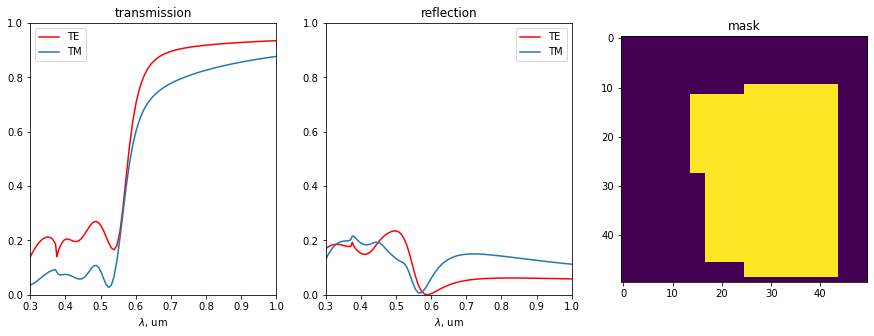

In [8]:
idx = np.random.randint(0,data.__len__()//3)
imshow(idx)

Along with a masked array

In [9]:
labels = get_labels(idx)
labels

array([{'rectangle': [(31, 41), 18, 13]}], dtype=object)

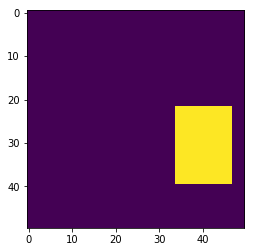

In [10]:
from shapes import Canvas
canvas = np.zeros([50,50],dtype=np.int32)
shape = Canvas.from_labels(canvas, labels)
plt.imshow(shape.mask)
plt.show()

Let's have a closer look on a dataset structure

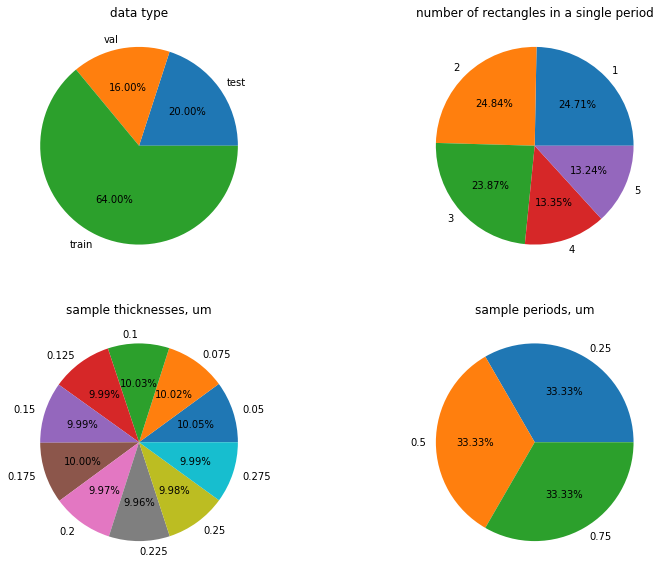

In [11]:
plt.figure(figsize=[13,10])
#
plt.subplot(221)
plt.axis('off')
plt.title('data type')
labels = ['test','val','train']
freqs = []
for label in labels:
    freq = data[data.status == label].__len__() / data.__len__() * 100
    freqs.append(freq)
plt.pie(freqs, labels = labels,autopct='%1.2f%%')
#
plt.subplot(222)
plt.axis('off')
plt.title('number of rectangles in a single period')
labels = np.unique(nshapes.values)
freqs = []
for label in labels:
    freq = nshapes[nshapes == label].__len__() / nshapes.__len__() * 100
    freqs.append(freq)
plt.pie(freqs, labels = labels,autopct='%1.2f%%')
#
plt.subplot(223)
plt.axis('off')
plt.title('sample thicknesses, um')
labels = np.unique(data.dz.values)
freqs = []
for label in labels:
    freq = data[data.dz == label].__len__() / data.__len__() * 100
    freqs.append(freq)
plt.pie(freqs, labels = labels,autopct='%1.2f%%')
#
plt.subplot(224)
plt.axis('off')
plt.title('sample periods, um')
labels = np.unique(data.nx.values)
freqs = []
for label in labels:
    freq = data[data.nx == label].__len__() / data.__len__() * 100
    freqs.append(freq)
plt.pie(freqs, labels = labels*0.005,autopct='%1.2f%%')
plt.show()

As you can see, this particular dataset contains hundred of thousands samples splitted in train, validation and test parts, with multiple thicknesses and periods. 

## Generators

The most important part of this stage are provided in data.py source file. 

Different instances of a class 

In [12]:
from data import DataSet2 as DataSet

Using TensorFlow backend.


In [36]:
input_size = [56,56]
data = DataSet(npoints=80, datafile='data_rect_50_50',input_shape=input_size)

In [37]:
batch_size = 5
generator = data.frame_generator(batch_size=batch_size,train_val_test='test')
i = iter(generator)

In [38]:
X, y = next(i)
X.shape

Creating test generator with 40000 samples.


(5, 56, 56, 1)

sample 0


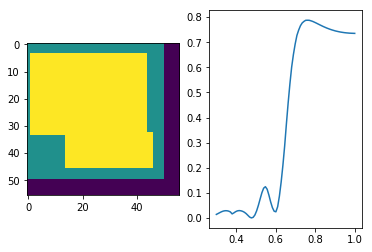

sample 1


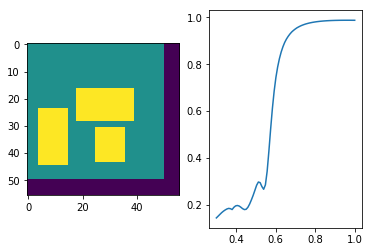

sample 2


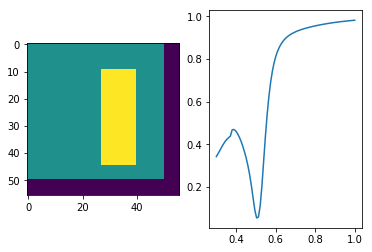

sample 3


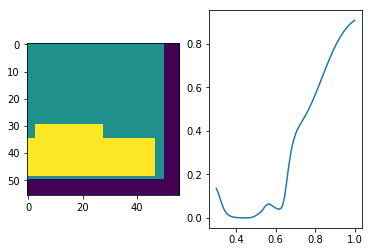

sample 4


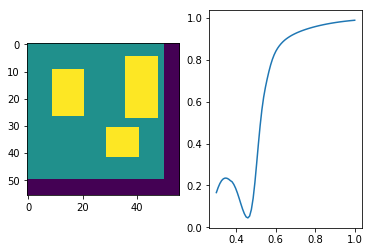

In [42]:
def xy_show(x, y):
    plt.subplot(121)
    plt.imshow(x)
    plt.subplot(122)
    wl = np.linspace(0.3, 1.0, len(y))
    plt.plot(wl,y)
    plt.show()

for i in range(batch_size):
    print('sample',i)
    xy_show(X[i].reshape(input_size),y[i])

## Augmentation

Since we are working with periodic structures our system has translation invariant. So, if we randomly shift the whole structure its flat output response shouldn't change, while its input will be substantially different for a framework. By including a random translation in our data generator we can significantly increase a dataset and hopefully oure system will learn that periodic rule. 

Also, since we have an information about both polarization we can rotate our structure by 90 degrees and increase dataset twice. 

In DEEPNANO you can add this augmentation transfromations very easily by specifying corresponding arguments in generator functions. 

In [43]:
generator = data.frame_generator(batch_size=batch_size
                                 ,train_val_test='test'
                                 ,random_orientation=True
                                 ,random_translation=True)